In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def sin(x,T=100) :
    return np.sin(2.0*np.pi*x/T)

In [3]:
def toy_problem(T=100,ampl=0.05) :
    x=np.arange(0,2*T+1)
    noise=ampl*np.random.uniform(low=-1,high=1,size=len(x))
    return sin(x)+noise

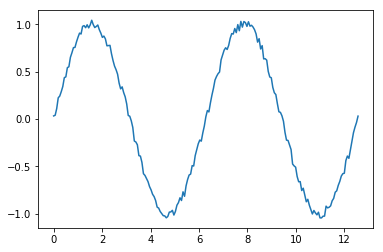

In [4]:
f=toy_problem(T=100,ampl=0.05)
x=np.arange(0,200+1)*(np.pi*4)/200
plt.plot(x,f)

## keras

In [5]:
length_of_sequence=2*100
maxlen=25

data=[]
target=[]
for i in range(0,length_of_sequence-maxlen+1) :
    data.append(f[i:(i+maxlen)])
    target.append(f[i+maxlen])

In [6]:
X=np.array(data)
X=np.array(data).reshape(len(data),maxlen,1)
y=np.array(target).reshape(len(data),1)

In [7]:
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, y, epochs=30, batch_size=10, verbose=2, validation_split=0.3)

Train on 123 samples, validate on 53 samples
Epoch 1/30
 - 1s - loss: 0.4756 - val_loss: 0.3796
Epoch 2/30
 - 0s - loss: 0.2103 - val_loss: 0.2386
Epoch 3/30
 - 0s - loss: 0.1253 - val_loss: 0.1165
Epoch 4/30
 - 0s - loss: 0.0875 - val_loss: 0.0696
Epoch 5/30
 - 0s - loss: 0.0647 - val_loss: 0.0588
Epoch 6/30
 - 0s - loss: 0.0485 - val_loss: 0.0465
Epoch 7/30
 - 0s - loss: 0.0357 - val_loss: 0.0312
Epoch 8/30
 - 0s - loss: 0.0233 - val_loss: 0.0191
Epoch 9/30
 - 0s - loss: 0.0130 - val_loss: 0.0089
Epoch 10/30
 - 0s - loss: 0.0053 - val_loss: 0.0030
Epoch 11/30
 - 0s - loss: 0.0026 - val_loss: 0.0026
Epoch 12/30
 - 0s - loss: 0.0024 - val_loss: 0.0027
Epoch 13/30
 - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 14/30
 - 0s - loss: 0.0019 - val_loss: 0.0021
Epoch 15/30
 - 0s - loss: 0.0018 - val_loss: 0.0020
Epoch 16/30
 - 0s - loss: 0.0016 - val_loss: 0.0017
Epoch 17/30
 - 0s - loss: 0.0017 - val_loss: 0.0016
Epoch 18/30
 - 0s - loss: 0.0017 - val_loss: 0.0016
Epoch 19/30
 - 0s - loss: 0.

In [8]:
y_hat = model.predict(X)

In [9]:
X.shape,X[:,0,:].shape

((176, 25, 1), (176, 1))

In [10]:
Z=X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequence-maxlen+1):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
       (z_.reshape(maxlen, 1)[1:], y_), axis=0).reshape(1, maxlen, 1)
    Z=np.append(z_, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

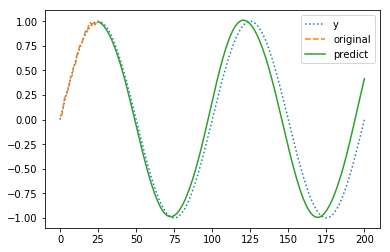

In [11]:
plt.plot(toy_problem(T=100, ampl=0), linestyle="dotted")
plt.plot(original, linestyle="dashed")
plt.plot(predicted)
plt.legend(["y","original","predict"])

## tensorflow

In [12]:
import tensorflow as tf

In [13]:
n_in=1  # n-in
n_out=1   # n-out

maxlen=25 # maxlen
n_hidden=30  # n_hidden
forget_bias=1.0  # 망각편행 (기본값 1.0)
num_stacked_layers=1  # stacked LSTM layers 갯수

epoch_num=1000  # epoch
learning_rate=0.01

In [14]:
# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(X) * 0.9)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(y) - train_size
 
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])
 
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])

In [15]:
X=tf.placeholder(tf.float32,[None,maxlen,n_in])   # input data
Y=tf.placeholder(tf.float32,[None,1])             # output data (true)

targets=tf.placeholder(tf.float32,[None,1])       # true value
predictions=tf.placeholder(tf.float32,[None,1])   # predicted value

In [16]:
num_hidden = 30
def lstm_cell() :
    cell = tf.nn.rnn_cell.LSTMCell(num_hidden,forget_bias=forget_bias,
                                    state_is_tuple=True,activation=tf.nn.softsign)
        #If state_is_tuple=True, accepted and returned states are 2-tuples of the `c_state` and `m_state`
    return cell

In [20]:
stackedRNNs=[lstm_cell() for _ in range(num_stacked_layers)]
multi_cells=tf.contrib.rnn.MultiRNNCell(stackedRNNs,state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()
                # RNN cell composed sequentially of multiple simple cells.

In [20]:
hypothesis, _states=tf.nn.dynamic_rnn(multi_cells,X,dtype=tf.float32)
                # Creates a recurrent neural network specified by RNNCell `cell`.

In [21]:
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], n_out, activation_fn=tf.identity)
                # Adds a fully connected layer.
                # Returns: The tensor variable representing the result of the series of operations.

In [22]:
loss=tf.reduce_sum(tf.square(hypothesis-Y))  # hypothesis : yhat  Y : true
optimizer=tf.train.AdamOptimizer(learning_rate)

In [23]:
train=optimizer.minimize(loss)

In [24]:
rmse=tf.sqrt(tf.reduce_mean(tf.squared_difference(targets,predictions)))

In [25]:
train_error_summary=[]
test_error_summary=[]
test_predict=''

In [26]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

In [27]:
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}".format(epoch+1, train_error, test_error))


epoch: 100, train_error(A): 0.0330936424434185, test_error(B): 0.03965972363948822
epoch: 200, train_error(A): 0.03199698030948639, test_error(B): 0.039070021361112595
epoch: 300, train_error(A): 0.031202804297208786, test_error(B): 0.03775999695062637
epoch: 400, train_error(A): 0.030527954921126366, test_error(B): 0.03694497421383858
epoch: 500, train_error(A): 0.030081050470471382, test_error(B): 0.03662295266985893
epoch: 600, train_error(A): 0.02941262535750866, test_error(B): 0.03589935600757599
epoch: 700, train_error(A): 0.028727930039167404, test_error(B): 0.035014569759368896
epoch: 800, train_error(A): 0.029073582962155342, test_error(B): 0.03551355004310608
epoch: 900, train_error(A): 0.028263337910175323, test_error(B): 0.03523443639278412
epoch: 1000, train_error(A): 0.02774849906563759, test_error(B): 0.03541535511612892


In [28]:
epochs=1000
batch_size=10
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = len(trainX) // batch_size
from sklearn.utils import shuffle

In [29]:
my_loss = []
for epoch in range(epochs):
    X_, Y_ = shuffle(trainX, trainY)
    
    for i in range(n_batches):
        start = i* batch_size
        end = start + batch_size
    
    sess.run(train, feed_dict={
        X: X_[start:end], 
        Y: Y_[start:end]
    })
    
    val_loss = loss.eval(session=sess, feed_dict={
        X: testX, 
        Y: testY
    })
    my_loss.append(val_loss)
    
    if epoch%50==0 :
        print("epoch:", epoch, "validation loss:", val_loss)
print("epoch:", epoch, "validation loss:", my_loss[-1])

epoch: 0 validation loss: 4.867318
epoch: 50 validation loss: 0.050940014
epoch: 100 validation loss: 0.03227663
epoch: 150 validation loss: 0.031623192
epoch: 200 validation loss: 0.028093051
epoch: 250 validation loss: 0.045136765
epoch: 300 validation loss: 0.033245973
epoch: 350 validation loss: 0.030391403
epoch: 400 validation loss: 0.042226277
epoch: 450 validation loss: 0.043799687
epoch: 500 validation loss: 0.033298608
epoch: 550 validation loss: 0.045119725
epoch: 600 validation loss: 0.02855884
epoch: 650 validation loss: 0.027956735
epoch: 700 validation loss: 0.035414644
epoch: 750 validation loss: 0.032760274
epoch: 800 validation loss: 0.044246662
epoch: 850 validation loss: 0.03614689
epoch: 900 validation loss: 0.046135135
epoch: 950 validation loss: 0.035657883
epoch: 999 validation loss: 0.04677797


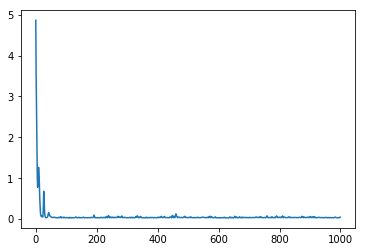

In [30]:
plt.plot(my_loss)

In [31]:
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

In [32]:
for i in range(0,train_predict.shape[0]) :
    predicted.append(train_predict[i])
for i in range(0,test_predict.shape[0]) :
    predicted.append(test_predict[i])

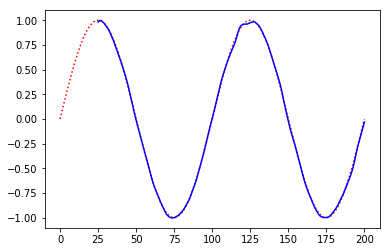

In [33]:
plt.plot(toy_problem(T=100, ampl=0),'r', linestyle="dotted")
plt.plot(predicted, 'b')